## Problem Statement:

For a B2B SaaS organization, demand generation can result in hundreds of new leads every day. Understanding the quality of leads, and which leads are likely to convert is critical as it enables the sales team to focus their efforts on low-hanging fruit. The typical B2B sales funnel starts with top of funnel metrics such as leads, narrowing as the leads are increasingly qualified and progress to sales opportunities, and potentially closed won deals. 

This model uses demographic and behavioural information for each lead, and predicts whether the lead will become a sales accepted opportunity (SAO) by classifying the lead as either likely to convert, or not likely to convert. This helps then sales team or business development / sales reps to tailor their attention to the leads with the highest potential to become an opportunity, and eventually revenue. 

The end result of this notebook is a Random Forest Classifier model that predicts wheter a lead will become an SAO with over 99% accuracy and 81.5% precision. Given that sales rep time is the constrained resource and leads are plentiful, precision is the key evaluation metric here. A false positive (saying a lead is quality when it is not) is more costly than a false negative (saying a quality lead is not worth working) in this situation.

![title](img/b2bfunnel.png)

## Import Packages & Dataset

In [2]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Dataset:

I wrote a query to combine data from the following sources, and then exported the data as a csv so I could scrub and anonymize the data. To implement the model, connecting directly to the datawarehouse would be preferred. 

1. In-app behavioural data (including Segment event data), 
2. Third party enrichment data for demographic information at the company level (not the individual level)
3. CRM leads data

I joined datasources 1 & 2 to the CRM leads data, so the end result is one row per lead.

Note: The dataset does not contain any PII, and internal and test leads were excluded from the dataset

In [3]:
#import data

df = pd.read_csv('data/leads_data_clean.csv')

#convert columns names to lowercase
df.columns = map(str.lower, df.columns)
df.head()

,is_sao,demographic_1,demographic_2,demographic_3,demographic_4,demographic_5,demographic_6,behavioural_1,behavioural_2,behavioural_3,...,behavioural_8,behavioural_9,behavioural_10,behavioural_11,behavioural_12,behavioural_13,behavioural_14,behavioural_15,behavioural_16,behavioural_17
0,0,NaN,Education Services,Diversified Consumer Services,Education,Consumer Discretionary,1390.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,0,NaN,"Hotels, Restaurants & Leisure",Consumer Services,"Hotels, Restaurants & Leisure",Consumer Discretionary,30.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,0,NaN,Media,Media,Advertising,Consumer Discretionary,5570.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,0,NaN,Health Care Providers & Services,Health Care Equipment & Services,Health & Wellness,Health Care,240.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


## Explore features & dataset

### Dataset description:

- is_sao is the target variable (whether a lead became a sales accepted opportunity)
- demographic features contain third party enrichment data related to the company each lead is associated with (no PII)
- remainining features are behavioural, in the form of a count of the number of times the action was performed by the lead


In [6]:
from pandas_profiling import ProfileReport
ProfileReport(df)

In [217]:
#can see dataset contains 27 different features
df.shape

(131108, 24)

In [218]:
#several of the features appear to be binary, mix of categorical and continuous features 
df.describe()

,is_sao,demographic_6,behavioural_1,behavioural_2,behavioural_3,behavioural_4,behavioural_5,behavioural_6,behavioural_7,behavioural_8,behavioural_9,behavioural_10,behavioural_11,behavioural_12,behavioural_13,behavioural_14,behavioural_15,behavioural_16,behavioural_17
count,131108.000000,6.162400e+04,131108.000000,131108.000000,131108.00000,131108.000000,77254.000000,7300.0,16315.000000,126577.0,126577.000000,126577.000000,126577.000000,126577.000000,126577.000000,137.000000,74.000000,38.000000,0.0
mean,0.003821,1.128875e+04,0.002937,0.565076,0.02816,0.011365,3.887850,1.0,2.368005,1.0,2.841298,10.009978,7.389944,0.529946,0.616644,1.197080,1.324324,4.000000,NaN
std,0.061698,6.192144e+04,0.183691,0.495749,0.16543,0.105998,4.535759,0.0,4.651154,0.0,19.229753,105.479512,141.985364,8.952390,8.394210,0.566717,0.551663,6.251486,NaN
min,0.000000,1.000000e+00,0.000000,0.000000,0.00000,0.000000,1.000000,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,NaN
25%,0.000000,1.280000e+02,0.000000,0.000000,0.00000,0.000000,1.000000,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,NaN
50%,0.000000,6.600000e+02,0.000000,1.000000,0.00000,0.000000,3.000000,1.0,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.500000,NaN
75%,0.000000,4.850000e+03,0.000000,1.000000,0.00000,0.000000,5.000000,1.0,2.000000,1.0,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.750000,NaN
max,1.000000,2.300000e+06,15.000000,1.000000,1.00000,1.000000,147.000000,1.0,132.000000,1.0,2817.000000,21264.000000,40322.000000,2667.000000,2271.000000,5.000000,3.000000,35.000000,NaN


#### Observations: 

Can see the many of the behavioural features are binary, but there are several continous features that will need to be scaled later on so that the model doesn't over-emphasize their importance.

We should also analyze the distributions of these features and remove any outliers.

In [219]:
#look at % of missing values by feature

missing_values = df.isna().sum()

percent_missing_features = missing_values/len(df)*100
percent_missing_features

is_sao              0.000000
demographic_1      91.636666
demographic_2      52.227934
demographic_3      52.227934
demographic_4      52.227934
demographic_5      52.227934
demographic_6      52.997529
behavioural_1       0.000000
behavioural_2       0.000000
behavioural_3       0.000000
behavioural_4       0.000000
behavioural_5      41.076059
behavioural_6      94.432071
behavioural_7      87.556061
behavioural_8       3.455929
behavioural_9       3.455929
behavioural_10      3.455929
behavioural_11      3.455929
behavioural_12      3.455929
behavioural_13      3.455929
behavioural_14     99.895506
behavioural_15     99.943558
behavioural_16     99.971016
behavioural_17    100.000000
dtype: float64

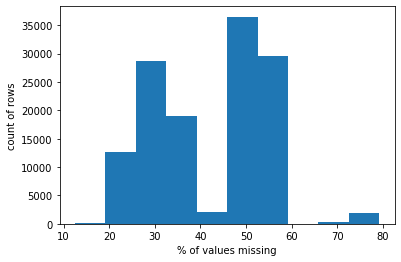

In [220]:
#look at % missing values by row 

missing_values = df.isna().sum(axis=1)

percent_missing_rows = missing_values/df.shape[1]*100

# fig = plt.figure(figsize=(25,10))
plt.hist(percent_missing_rows)
plt.xlabel('% of values missing')
plt.ylabel('count of rows')
plt.show()

### Check for Nulls

In [221]:
#check for null values
df.isna().sum()

is_sao                 0
demographic_1     120143
demographic_2      68475
demographic_3      68475
demographic_4      68475
demographic_5      68475
demographic_6      69484
behavioural_1          0
behavioural_2          0
behavioural_3          0
behavioural_4          0
behavioural_5      53854
behavioural_6     123808
behavioural_7     114793
behavioural_8       4531
behavioural_9       4531
behavioural_10      4531
behavioural_11      4531
behavioural_12      4531
behavioural_13      4531
behavioural_14    130971
behavioural_15    131034
behavioural_16    131070
behavioural_17    131108
dtype: int64

In [222]:
#we can fill NaNs for numerical columns with 0 
columns = df.iloc[:,7:].columns

def fill_na(df,columns,value):
    for col in columns:
        df[col].fillna(value=value,inplace=True)
    return df
        
fill_na(df=df,columns=columns,value=0)


,is_sao,demographic_1,demographic_2,demographic_3,demographic_4,demographic_5,demographic_6,behavioural_1,behavioural_2,behavioural_3,...,behavioural_8,behavioural_9,behavioural_10,behavioural_11,behavioural_12,behavioural_13,behavioural_14,behavioural_15,behavioural_16,behavioural_17
0,0,NaN,Education Services,Diversified Consumer Services,Education,Consumer Discretionary,1390.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,NaN,"Hotels, Restaurants & Leisure",Consumer Services,"Hotels, Restaurants & Leisure",Consumer Discretionary,30.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,NaN,Media,Media,Advertising,Consumer Discretionary,5570.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,NaN,Health Care Providers & Services,Health Care Equipment & Services,Health & Wellness,Health Care,240.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131103,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131104,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131105,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131106,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [223]:
#replace NaNs in categorical columns with string 'none'
categorical_columns = df.iloc[:,1:6]

fill_na(df=df,columns=categorical_columns,value='none')

,is_sao,demographic_1,demographic_2,demographic_3,demographic_4,demographic_5,demographic_6,behavioural_1,behavioural_2,behavioural_3,...,behavioural_8,behavioural_9,behavioural_10,behavioural_11,behavioural_12,behavioural_13,behavioural_14,behavioural_15,behavioural_16,behavioural_17
0,0,none,Education Services,Diversified Consumer Services,Education,Consumer Discretionary,1390.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,none,"Hotels, Restaurants & Leisure",Consumer Services,"Hotels, Restaurants & Leisure",Consumer Discretionary,30.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,none,Media,Media,Advertising,Consumer Discretionary,5570.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,none,Health Care Providers & Services,Health Care Equipment & Services,Health & Wellness,Health Care,240.0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,none,none,none,none,none,NaN,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131103,0,none,none,none,none,none,NaN,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131104,0,none,none,none,none,none,NaN,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131105,0,none,none,none,none,none,NaN,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131106,0,none,none,none,none,none,NaN,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
df.isna().sum()

is_sao                0
demographic_1         0
demographic_2         0
demographic_3         0
demographic_4         0
demographic_5         0
demographic_6     69484
behavioural_1         0
behavioural_2         0
behavioural_3         0
behavioural_4         0
behavioural_5         0
behavioural_6         0
behavioural_7         0
behavioural_8         0
behavioural_9         0
behavioural_10        0
behavioural_11        0
behavioural_12        0
behavioural_13        0
behavioural_14        0
behavioural_15        0
behavioural_16        0
behavioural_17        0
dtype: int64

### Check for outliers

Replace with mean values


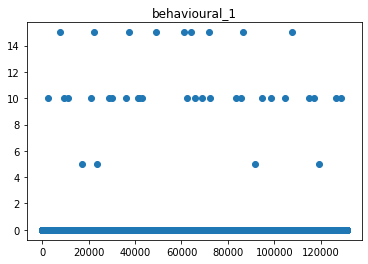

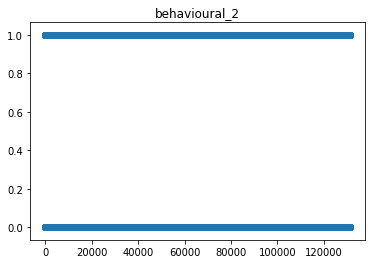

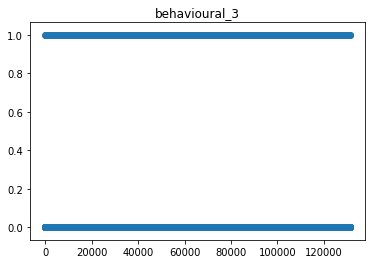

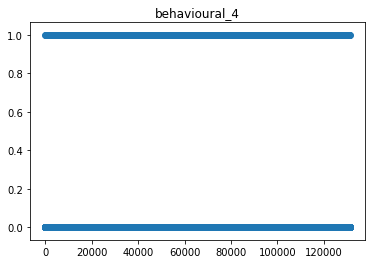

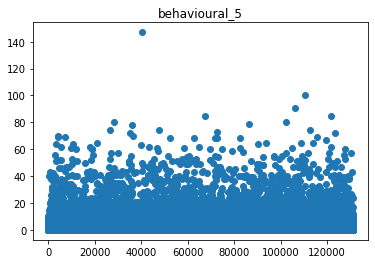

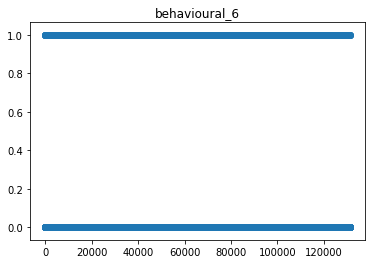

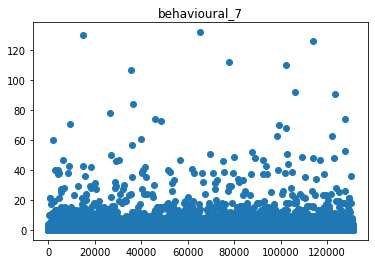

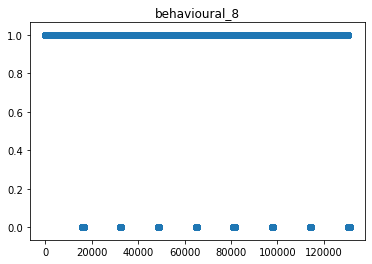

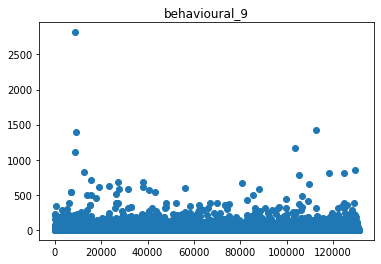

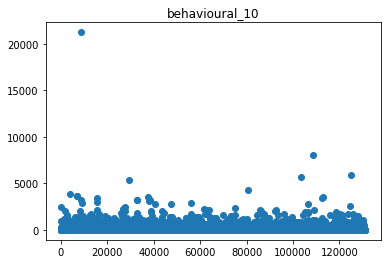

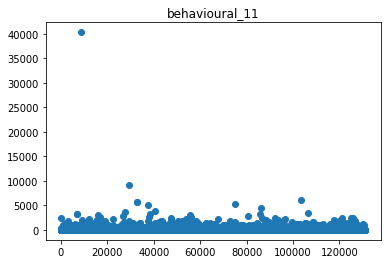

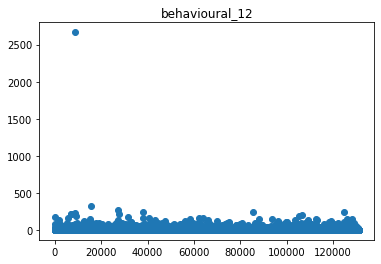

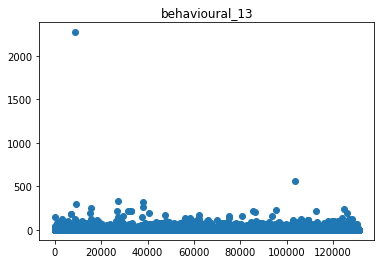

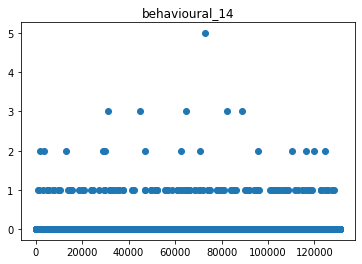

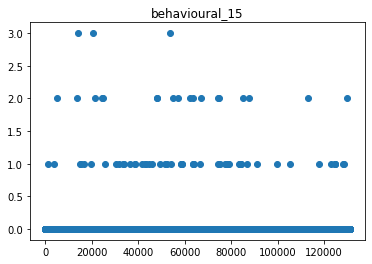

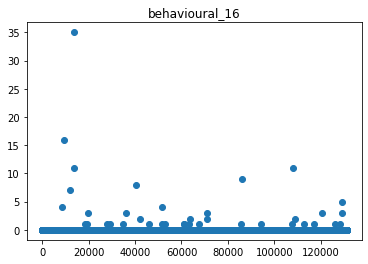

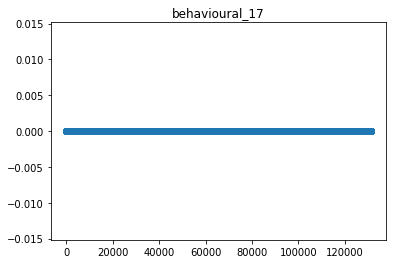

In [225]:
behavioural_columns = df.iloc[:,7:].columns

for col in behavioural_columns:
    x = df.index
    y = df[col]
    plt.scatter(x,y)
    plt.title(col)
    plt.show()

Can see that while most features are binary, the following features have outliers that should be removed:

- behavioural_5
- behavioural_9
- behavioural_10
- behavioural_11
- behavioural_12
- behavioural_13
- behavioural_16

It looks like these outliers values might belong to a single row,  which would make life easier. 

In [226]:
outlier_columns = ['behavioural_5','behavioural_9','behavioural_10','behavioural_11','behavioural_12','behavioural_13','behavioural_16']

for col in outlier_columns:
    outlier = df[col].max()
    outlier_index = df.index[df[col]==outlier].tolist()
    df.replace(to_replace=df[col].iloc[outlier_index],value=df[col].mean())

### Impute values for demographic_6 (only quantitative demographic feature)

In [227]:
#determine whether demographic_6 is continous or categorical
#can see that is is not a categorical variable as I thought, will need to impute values
df['demographic_6'].value_counts().sort_values(ascending=False)

150.0       2826
30.0        2176
20760.0     2001
4001.0      1859
5.0         1478
            ... 
224.0          1
2890.0         1
17080.0        1
31800.0        1
148000.0       1
Name: demographic_6, Length: 1951, dtype: int64

11288.753245488771


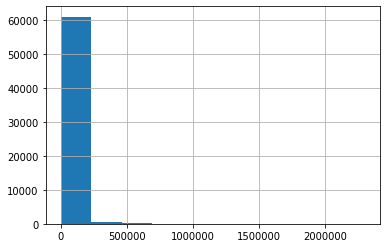

In [228]:
#fill NaNs with the mean value (don't want to use median because it's zero due to nulls) 
#confirm that filling with the mean appears reasonable based on distribution & value counts
df['demographic_6'].hist();
print(df['demographic_6'].mean())


In [229]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df['demographic_6'] = pd.DataFrame(imp.fit_transform(df[['demographic_6']]))
df['demographic_6'].value_counts()

11288.753245     69484
150.000000        2826
30.000000         2176
20760.000000      2001
4001.000000       1859
                 ...  
26650.000000         1
5390.000000          1
6660.000000          1
18440.000000         1
148000.000000        1
Name: demographic_6, Length: 1952, dtype: int64

### One-hot-encode categorical data

In [231]:
#now create dummy columns for categorical variables

dummy_df = pd.get_dummies(categorical_columns,dtype=int)
df = pd.concat([df,dummy_df],axis=1)

### Drop original categorical columns

In [232]:
df.drop(columns=categorical_columns,inplace=True)

#confirm all columns are either int or float
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131108 entries, 0 to 131107
Columns: 205 entries, is_sao to demographic_5_Utilities
dtypes: float64(14), int64(191)
memory usage: 205.1 MB


### Divide data into train & test 

Do this before scaling data to avoid biasing the test data with mean and std from complete dataset

In [240]:
target = ["is_sao"]

y = df["is_sao"]
X = df.drop(target,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y)

### Scale data - Standardize continous features

Note: depending on algorithms used, we may not need to standardize the data. Only distance based algorithms will benefit from standardized data

In [128]:
#determine which columns need to be scaled by looking at columns with a max value > 1
for col in df.columns:
    if df[col].max() > 1:
        print(col)

demographic_6
behavioural_1
behavioural_5
behavioural_7
behavioural_9
behavioural_10
behavioural_11
behavioural_12
behavioural_13
behavioural_14
behavioural_15
behavioural_16


As all the behavioural columns are a count of the number of times an action was performed, there is no need to scale these given the align with how the model will interpret the scale of the feature. 

In contrast, the demographic_6 column will need to be scaled to ensure it is not over-weighted or emphasized by the model 

In [129]:
def standardize_data(X_train,columns):
    for col in columns: 
#         data = np.array(df[col])
        scaler = StandardScaler()
        X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1,1))
    return X_train

In [130]:
continuous_columns = ['demographic_6']

X_train_scaled = standardize_data(X_train,continuous_columns)

/Users/erinhayes/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Build pipeline

In [241]:
def fit_random_forest_classifier(X,y,scale_data,n_estimators,max_depth,min_samples_split):
    '''
    INPUT: data, boolean for whether we want to scale the data, and specify hyperparameters
    OUTPUT: none - prints the accuracy, precision & recall scores for the model
    '''
        
    #divide data into test and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    #determine whether to scale data
    if scale_data == True:
        X_train = standardize_data(X_train,continuous_columns)
        X_test = standardize_data(X_test,continuous_columns)
    
    #instantiate model
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,min_samples_split=min_samples_split)
    
    #fit model
    model = clf.fit(X_train, y_train)
        
    #predict
    y_preds = clf.predict(X_test)

    #score
    acc = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    fbeta = fbeta_score(y_test, y_preds,beta=.5)
    
    print(f"accuracy score = {acc}".format(acc=acc))
    print(f"precision = {precision}".format(precision=precision))
    print(f"recall = {recall}".format(recall=recall))
    print(f"fbeta = {fbeta}".format(fbeta=fbeta))

In [242]:
def fit_model(X,y,scale_data,model_type):
    """ 
    define generic function to instantiate & fit model, return evaluation metrics
    
    """
    #divide data into test and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    #determine whether to scale data
    if scale_data == True:
        X_train = standardize_data(X_train,continuous_columns)
        X_test = standardize_data(X_test,continuous_columns)
    
    #instantiate model
    clf = model_type()
    
    #fit model
    model = clf.fit(X_train, y_train)
        
    #predict
    y_preds = clf.predict(X_test)

    #score
    acc = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    fbeta = fbeta_score(y_test, y_preds,beta=.5)
    
    print(f"accuracy score = {acc}".format(acc=acc))
    print(f"precision = {precision}".format(precision=precision))
    print(f"recall = {recall}".format(recall=recall))
    print(f"fbeta = {fbeta}".format(fbeta=fbeta))

### Experiment with different algorithms

#### Random Forest Classifier

In [41]:
#instantiate, fit & predict, return accuracy, precision, recall and fbeta scors
fit_random_forest_classifier(X,y,scale_data=False, n_estimators=100,max_depth=30,min_samples_split=4)

accuracy score = 0.9967642028382564
precision = 0.6885245901639344
recall = 0.25766871165644173
fbeta = 0.5159705159705159


(0.9967642028382564,
 0.6885245901639344,
 0.25766871165644173,
 0.5159705159705159)

#### Logistic Regression

In [48]:
fit_model(X,y, scale_data=False, model_type=LogisticRegression)

/Users/erinhayes/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy score = 0.9961632690796468
precision = 0.3333333333333333
recall = 0.018404907975460124
fbeta = 0.07537688442211055


/Users/erinhayes/opt/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(0.9961632690796468,
 0.3333333333333333,
 0.018404907975460124,
 0.07537688442211055)

In [49]:
fit_model(X,y, scale_data=False, model_type=DecisionTreeClassifier)

accuracy score = 0.9964175102852124
precision = 0.527027027027027
recall = 0.4785276073619632
fbeta = 0.5165562913907286


(0.9964175102852124, 0.527027027027027, 0.4785276073619632, 0.5165562913907286)

### Evaluate Model

While we want to evaluate the model's accuracy, note that we are more concerned with false positives (precision) in this situation.

Given that lead volumne is high, the purpose of this model is to flag users that are highly engaged with the self-serve version of the product. A false positive would waste the time of the BDR reps, diverting their attention from other leads that are promising based on company demographic info from third party enrichment sources.


In [51]:
#determine % of leads that become SAO
df['is_sao'].sum()/len(df)*100

0.3821277115050188

#### Interpretation of results: 

We can see that the accuracy score is deceiving here, as it is masking the poor recall score this is because only .38 % of leads became sales accepted opportunities, meaning even if the model predicted 0 leads would become SAOs, it would still have an accuracy of over 99%

**Random forest classifier** performs the best in terms of precision, but it should be noted that it's recall score is very low. 

The **Decision tree classifier** performed best all-around. Although it produces a lower precision score than the RFC, it's recall is better.

Given we care most about precision, the RFC model seems to be the best choice. It should be noted that this model could result in a high number of false negatives, meaning the model could incorrectly classify high quality leads as being un-likely to become SAOs.



### Tune Model

Use GridSearchCV to tune model parameters

In [52]:
def tune_model(model_type,params,scorer):
    clf = model_type()
    grid = GridSearchCV(estimator=clf, param_grid=params,scoring=scorer)
    grid.fit(X_train,y_train)
    print(grid.best_score_)
    print(grid.best_params_)

#### Random Forest Classifier

In [53]:
scorer = make_scorer(precision_score)
params = [{'max_depth':[20,50,100],
          'n_estimators':[10,20,40,60,80,100,120,140],
          'min_samples_split':[2,4,6,8]}]

tune_model(RandomForestClassifier,params=params,scorer=scorer)

/Users/erinhayes/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8148165097702883
{'max_depth': 20, 'min_samples_split': 6, 'n_estimators': 120}


#### Decision Tree

In [57]:
scorer = make_scorer(precision_score)
params = [{'max_depth':[20,50,100],
          'min_samples_split':[2,4,6,8,10,12]}]

tune_model(DecisionTreeClassifier,params=params,scorer=scorer)


/Users/erinhayes/opt/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.5695419962436468
{'max_depth': 20, 'min_samples_split': 12}


### Re-build Model, evaluate on test data

After tuning hyperparameters, we achieved an precision score of 81.5% using the RFC model. This score is much higher than the tuned decision tree model, therefore we will use the RFC model. 

In [249]:
clf = RandomForestClassifier(n_estimators=120,max_depth=20,min_samples_split=6)
model = clf.fit(X_train,y_train)
y_preds = model.predict(X_test)
precision = precision_score(y_test,y_preds)
print(f"Precision score = {precision}".format(precision=precision))

Precision score = 0.775
